In [9]:
import os
from multiprocessing import Process
from collections import Counter
import calendar

from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
# replace all cells without numbers with NA
def replace_non_digit_string(data_frame):
    mask = ~data_frame[['Salary', 'BirthDate', 'Time']].apply(lambda col: col.astype(str).str.contains(r'\d')).any(axis=1)
    data_frame.loc[mask, ['Name', 'BirthDate', 'Time']] = pd.NA
    return data_frame


# remove all empty strings
def remove_empty_strings(data_frame):
    data_frame = data_frame.dropna(how='all')
    return data_frame


# remove all duplicates
def remove_duplicates(date_frame):
    date_frame = date_frame.drop_duplicates()
    return date_frame


# delete all lines between 1:00:00 and 3:00:00
def remove_by_time(data_frame):
    start_time = pd.to_datetime('01:00:00').time()
    end_time = pd.to_datetime('03:00:00').time()

    data_frame['Time'] = pd.to_datetime(data_frame['Time'], format='%H:%M:%S', errors='coerce').dt.time

    mask = (data_frame['Time'].notna()) & (data_frame['Time'] > start_time) & (data_frame['Time'] < end_time)
    data_frame.loc[mask, ['Name', 'BirthDate', 'Time']] = pd.NA
    return data_frame

In [21]:
'''
With a dataset of 1 million records, there was an attempt to run 4 methods in parallel (two at a time) to speed things up. 
The result was better by 0.1 second - in this block of code, parallel launch of functions is not relevant.
'''
df = pd.read_csv('.test_data_set.csv')

df.fillna('')

df = replace_non_digit_string(df)   
df = remove_empty_strings(df)
df = remove_duplicates(df)
df = remove_by_time(df)

In [ ]:
# get unique rows for every hour, get median values and mean values
def metrics_calculation(data_frame):
    data_frame['Time'] = pd.to_datetime(data_frame['Time'], format='%H:%M:%S').dt.time
    
    data_frame['Hour'] = pd.to_datetime(data_frame['Time'].astype(str), format='%H:%M:%S').dt.hour
   
    grouped = data_frame.groupby('Hour')

    unique_counts = grouped['Name'].nunique()
    mean_values = grouped['Salary'].mean()
    median_values = grouped['Salary'].median()

    result = pd.DataFrame({
        'UniqueCounts': unique_counts,
        'MeanValues': mean_values,
        'MedianValues': median_values
    })

    return result


metrics = metrics_calculation(df)

In [51]:
metrics = metrics_calculation(df)
merged_data_frame = pd.merge(df, metrics, on='Hour', how='outer')

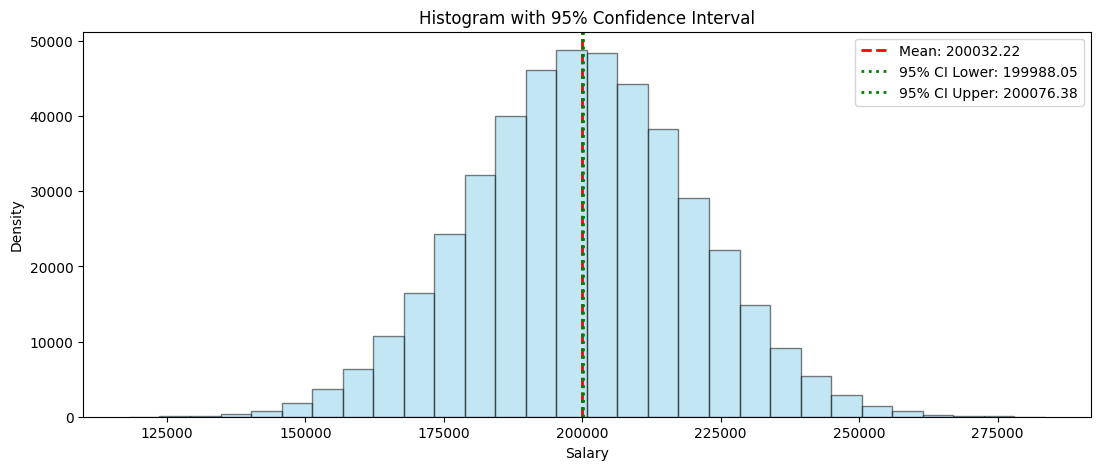

In [52]:
'''
Having a large sample and normal distribution of data, 
I calculated a confidence interval based on the sample - I used the z-distribution.
'''

sample = df['Salary']

# calculate mean and standart deviation
mean = np.mean(sample)
std_dev = np.std(sample, ddof=1)
n = len(sample)

# calculate of 95% confidience interval
confidience_level = 0.95
Z = stats.norm.ppf((1 + confidience_level)/2)

# formula for confidience interval
margin_of_error = Z * (std_dev / np.sqrt(n))
confidience_interval = (mean - margin_of_error, mean + margin_of_error)

plt.figure(figsize=(13, 5))

plt.hist(sample, bins=30, color='skyblue', alpha=0.5, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidience_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Lower: {confidience_interval[0]:.2f}')
plt.axvline(confidience_interval[1], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Upper: {confidience_interval[1]:.2f}')
plt.title('Histogram with 95% Confidence Interval')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

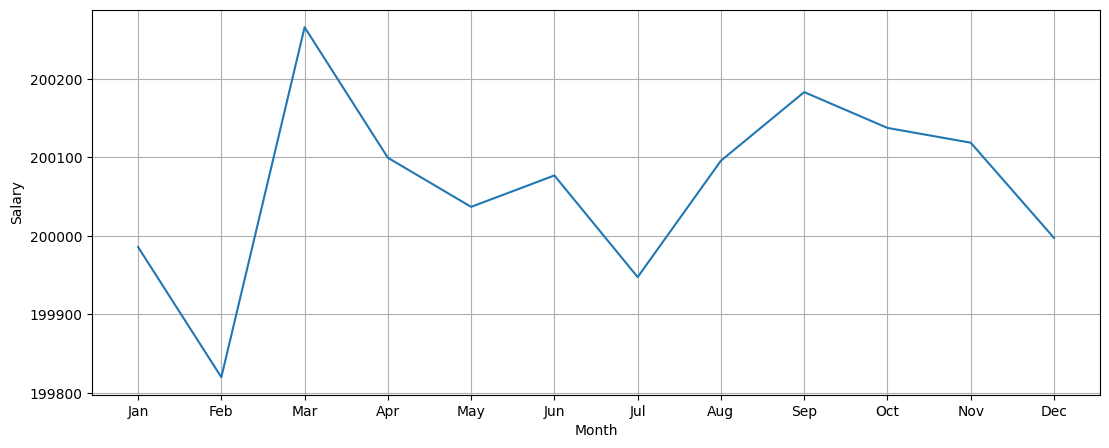

In [59]:
df['BirthDate'] = pd.to_datetime(df['BirthDate'])
df['month'] = df['BirthDate'].dt.month
monthly_mean = df.groupby('month')['Salary'].mean()

monthly_mean.index = [calendar.month_abbr[int(month)] for month in monthly_mean.index]

plt.figure(figsize=(13, 5))

plt.plot(monthly_mean.index, monthly_mean.values)
plt.xlabel('Month')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


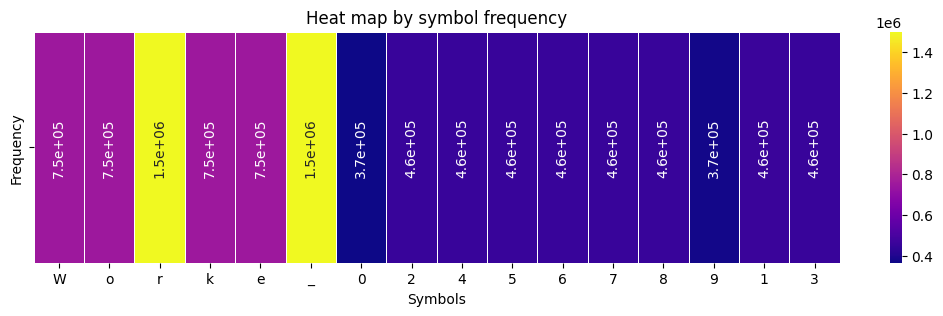

In [58]:
data = {'string': ['hello world', 'data science', 'heatmap example', 'hello data']}
# test_df = pd.DataFrame(data)
# test_df = df['Name']

def count_char_frequencies(texts):
    freq = Counter()
    for text in texts:
        if not pd.isna(text):
            freq.update(text)
    return dict(freq)

frequencies = count_char_frequencies(df['Name'])

frq_matrix = pd.DataFrame.from_dict(frequencies, orient='index', columns=['Frequency'])
frq_matrix = frq_matrix.T
frq_matrix

plt.figure(figsize=(13, 3))
sns.heatmap(frq_matrix, annot=True, cmap='plasma', linewidths=0.5, annot_kws={'size': 10, 'rotation': 90})
plt.title('Heat map by symbol frequency')
plt.xlabel('Symbols')
plt.show()
